<a href="https://colab.research.google.com/github/satoshi-yoshiji/HGEN670course_2025/blob/main/MR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exposure Data (VEGF):
   SNP  beta_exposure  se_exposure  pval_exposure
0  rs1           0.20         0.05   1.000000e-07
1  rs2           0.05         0.02   5.000000e-08
2  rs3          -0.10         0.04   1.000000e-05
3  rs4           0.25         0.05   1.000000e-06 

Outcome Data (BMD):
   SNP  beta_outcome  se_outcome  pval_outcome
0  rs1          0.10        0.03          0.02
1  rs2          0.05        0.04          0.05
2  rs3          0.03        0.02          0.01
3  rs4          0.12        0.03          0.03

Merged DataFrame:
   SNP  beta_exposure  se_exposure  pval_exposure  beta_outcome  se_outcome  \
0  rs1           0.20         0.05   1.000000e-07          0.10        0.03   
1  rs2           0.05         0.02   5.000000e-08          0.05        0.04   
2  rs3          -0.10         0.04   1.000000e-05          0.03        0.02   
3  rs4           0.25         0.05   1.000000e-06          0.12        0.03   

   pval_outcome  
0          0.02  
1          0.05  
2 

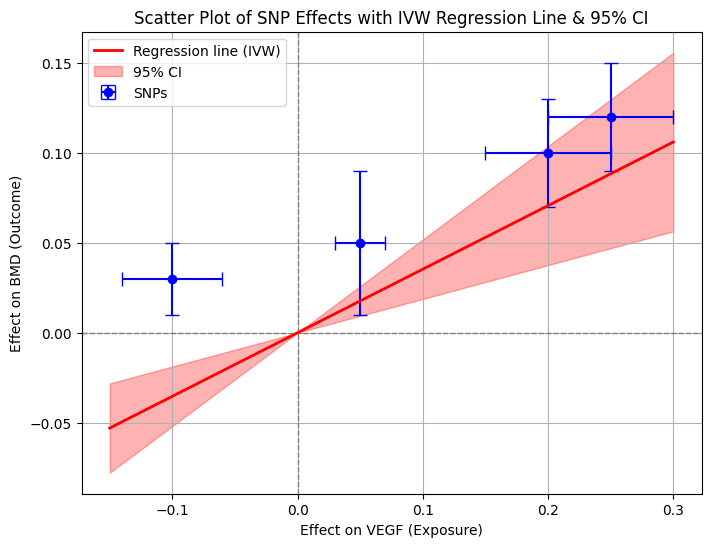


MR-Egger Regression Results:
                            WLS Regression Results                            
Dep. Variable:           beta_outcome   R-squared:                       0.976
Model:                            WLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     81.19
Date:                Sat, 15 Feb 2025   Prob (F-statistic):             0.0121
Time:                        21:19:37   Log-Likelihood:                 14.557
No. Observations:                   4   AIC:                            -25.11
Df Residuals:                       2   BIC:                            -26.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


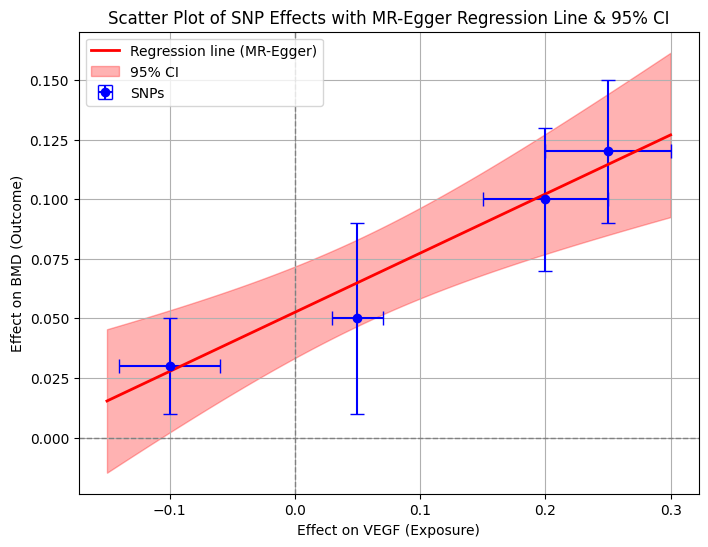

In [ ]:
#@title VEGF–BMD Mendelian Randomization Example

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

#%% [markdown]
# ## 1. Define the DataFrames (Exposure and Outcome)
#
# Here we create two DataFrames with summary statistics using the provided data.
#

# Data for the exposure (VEGF)
data_exposure = {
    'SNP': ['rs1', 'rs2', 'rs3', 'rs4'],
    'beta_exposure': [0.20, 0.05, -0.10, 0.25],
    'se_exposure': [0.05, 0.02, 0.04, 0.05],
    'pval_exposure': [1e-7, 5e-8, 1e-5, 1e-6]
}
df_exposure = pd.DataFrame(data_exposure)

# Data for the outcome (BMD)
data_outcome = {
    'SNP': ['rs1', 'rs2', 'rs3', 'rs4'],
    'beta_outcome': [0.10, 0.05, 0.03, 0.12],
    'se_outcome': [0.03, 0.04, 0.02, 0.03],
    'pval_outcome': [0.02, 0.05, 0.01, 0.03]
}
df_outcome = pd.DataFrame(data_outcome)

# Display the input data
print("Exposure Data (VEGF):")
print(df_exposure, "\n")
print("Outcome Data (BMD):")
print(df_outcome)

#%% [markdown]
# ## 2. Merge the Datasets
#
# Merge the exposure and outcome datasets on the SNP column.
#
df_merged = pd.merge(df_exposure, df_outcome, on='SNP')
print("\nMerged DataFrame:")
print(df_merged)

#%% [markdown]
# ## 3. Inverse-Variance Weighted (IVW) Mendelian Randomization
#
# The IVW method estimates the overall causal effect.
# The formula is:
#
# \[
# \hat{\beta}_{IVW} = \frac{\sum_i w_i \, \beta_{i,\text{outcome}} \, \beta_{i,\text{exposure}}}{\sum_i w_i \, \beta_{i,\text{exposure}}^2}
# \]
#
# where \( w_i = \frac{1}{\text{se}_{i,\text{outcome}}^2} \).

# Calculate weights based on outcome standard errors
w = 1 / (df_merged['se_outcome']**2)

# Compute numerator and denominator for IVW estimate
ivw_num = np.sum(w * df_merged['beta_outcome'] * df_merged['beta_exposure'])
ivw_den = np.sum(w * df_merged['beta_exposure']**2)

ivw_estimate = ivw_num / ivw_den
ivw_se = np.sqrt(1 / ivw_den)

# Compute p-value using a normal approximation
z_score = ivw_estimate / ivw_se
ivw_pvalue = 2 * norm.sf(abs(z_score))

print("\nIVW Estimate:", ivw_estimate)
print("IVW Standard Error:", ivw_se)
print("IVW p-value:", ivw_pvalue)

#%% [markdown]
# ### 3a. Visualization: Scatter Plot with IVW Regression Line and 95% CI
#
# In classical IVW, we typically assume no intercept (i.e., the line goes through the origin).
# So the fitted line is:
#
# \[
# \text{Outcome} = \hat{\beta}_{IVW} \times \text{Exposure}.
# \]
#
# For each exposure \( x \), the 95% CI is:
#
# \[
# \hat{\beta}_{IVW} \pm 1.96 \times \text{SE}(\hat{\beta}_{IVW}) \quad \text{(multiplied by } x\text{)}.
# \]

plt.figure(figsize=(8, 6))

# Plot the SNP data with error bars
plt.errorbar(
    df_merged['beta_exposure'], df_merged['beta_outcome'],
    xerr=df_merged['se_exposure'], yerr=df_merged['se_outcome'],
    fmt='o', capsize=5, color='blue', label='SNPs'
)

# Add dashed lines at x=0 and y=0
plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.axvline(0, color='grey', linestyle='--', lw=1)

# Prepare x-values for the IVW line
x_ivw = np.linspace(df_merged['beta_exposure'].min() - 0.05,
                    df_merged['beta_exposure'].max() + 0.05, 100)

# The slope is the IVW estimate; intercept = 0
slope = ivw_estimate
slope_upper = slope + 1.96 * ivw_se
slope_lower = slope - 1.96 * ivw_se

# Compute y-values for the line
y_ivw = slope * x_ivw
y_ivw_upper = slope_upper * x_ivw
y_ivw_lower = slope_lower * x_ivw

# Plot the IVW regression line
plt.plot(x_ivw, y_ivw, color='red', lw=2, label='Regression line (IVW)')

# Plot the 95% CI as a shaded region
plt.fill_between(x_ivw, y_ivw_lower, y_ivw_upper,
                 color='red', alpha=0.3, label='95% CI')

plt.xlabel("Effect on VEGF (Exposure)")
plt.ylabel("Effect on BMD (Outcome)")
plt.title("Scatter Plot of SNP Effects with IVW Regression Line & 95% CI")
plt.grid(True)
plt.legend()
plt.show()

#%% [markdown]
# ## 4. MR-Egger Regression
#
# MR-Egger regression serves as a sensitivity analysis that allows for directional pleiotropy.
# It is performed using a weighted linear regression of the outcome effects on the exposure effects (with an intercept).

X = df_merged['beta_exposure']
Y = df_merged['beta_outcome']
X_const = sm.add_constant(X)  # add intercept

model = sm.WLS(Y, X_const, weights=w)
results = model.fit()

print("\nMR-Egger Regression Results:")
print(results.summary())

#%% [markdown]
# ### 4a. Visualization: Scatter Plot with MR-Egger Regression Line and 95% CI
#
# This is similar to the IVW plot, but uses the fitted Egger regression line (which includes an intercept).

plt.figure(figsize=(8, 6))

# Plot the SNP data with error bars
plt.errorbar(
    df_merged['beta_exposure'], df_merged['beta_outcome'],
    xerr=df_merged['se_exposure'], yerr=df_merged['se_outcome'],
    fmt='o', capsize=5, color='blue', label='SNPs'
)

# Add dashed lines at x=0 and y=0
plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.axvline(0, color='grey', linestyle='--', lw=1)

# Create a range of x values for the Egger regression line
x_pred = np.linspace(df_merged['beta_exposure'].min() - 0.05,
                     df_merged['beta_exposure'].max() + 0.05, 100)
x_pred_const = sm.add_constant(x_pred)

predictions = results.get_prediction(x_pred_const)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Plot the Egger regression line
plt.plot(x_pred, pred_summary['mean'], color='red', lw=2, label='Regression line (MR-Egger)')
# Plot the 95% confidence interval as a shaded region
plt.fill_between(x_pred,
                 pred_summary['mean_ci_lower'],
                 pred_summary['mean_ci_upper'],
                 color='red', alpha=0.3, label='95% CI')

plt.xlabel("Effect on VEGF (Exposure)")
plt.ylabel("Effect on BMD (Outcome)")
plt.title("Scatter Plot of SNP Effects with MR-Egger Regression Line & 95% CI")
plt.grid(True)
plt.legend()
plt.show()